In [1]:
from __future__ import print_function, division
import os, sys, cv2
os.chdir("/home/asaeed9/work/deeplearning")
from theano.sandbox import cuda
#cuda.use('gpu1')
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
from keras.preprocessing import image, sequence
from shutil import copyfile, move
from random import shuffle

####
from keras.layers.convolutional import *
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
import datetime

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [2]:
data_dir="/home/asaeed9/work/data/2cat_18112017"
data_src="sample"
data_dir_F = data_dir + "/F_sample/"
#data_dir_F_sample = data_dir + "/F_sample/"
path="/home/asaeed9/work/data/2cat_18112017/" + data_src + "/"
results_path = "/home/asaeed9/work/data/2cat_18112017/"+ data_src + "/results"
test_path = path + '/test/' #We use all the test data

In [10]:
move_files("/home/asaeed9/work/data/2cat_debug/F/", "/home/asaeed9/work/data/2cat_debug/F_sample", "dog*.jpg", 2100)

In [3]:
def get_file_count(dir_path):
    return len([name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))])


def get_train_valid_size():
    tr_count = get_file_count(path + "/train/cats") + get_file_count(path + "/train/dogs")
    vl_count = get_file_count(path + "/valid/cats") + get_file_count(path + "/valid/dogs")

    return tr_count, vl_count

def move_files(src_path, dest_path, pattern, n):
    #     print(src_path)
    #     print(dest_path)
    #     print(pattern)
    #     print(n)

    os.chdir(src_path)

    try:
        if type(pattern) is np.ndarray:
            for img in pattern:
                move(os.path.join(src_path + '/', os.path.basename(img)),
                     os.path.join(dest_path + '/', os.path.basename(img)))
        else:
            if n:
                g = glob(src_path + '/' + pattern)
                shuf = np.random.permutation(g)
                for i in range(n):
                    move(os.path.join(src_path + '/', os.path.basename(shuf[i])),
                         os.path.join(dest_path + '/', os.path.basename(shuf[i])))
            else:
                for file in glob(src_path + '/' + pattern):
                    move(os.path.join(src_path + '/', os.path.basename(file)),
                         os.path.join(dest_path + '/', os.path.basename(file)))

    except IOError, e:
        print("Unable to move file - {}".format(e))


def prep_experiments():
    move_files(path + "/train/" + "/cats", data_dir_F, "cat*.jpg", None)
    move_files(path + "/train/" + "/dogs", data_dir_F, "dog*.jpg", None)

    move_files(path + "/valid/" + "/cats", data_dir_F, "cat*.jpg", None)
    move_files(path + "/valid/" + "/dogs", data_dir_F, "dog*.jpg", None)

    move_files(path + "/unlabel/" + "/cats", data_dir_F, "cat*.jpg", None)
    move_files(path + "/unlabel/" + "/dogs", data_dir_F, "dog*.jpg", None)

    move_files(path + "/test/" + "/cats", data_dir_F, "cat*.jpg", None)
    move_files(path + "/test/" + "/dogs", data_dir_F, "dog*.jpg", None)

    
def prep_experiment2(block):
    move_files(path + "/train/" + "/cats", data_dir_F, "cat*.jpg", None)
    move_files(path + "/train/" + "/dogs", data_dir_F, "dog*.jpg", None)

    move_files(path + "/valid/" + "/cats", data_dir_F, "cat*.jpg", None)
    move_files(path + "/valid/" + "/dogs", data_dir_F, "dog*.jpg", None)

    print("Training/Validation images moved to set F.")

    move_block_images(block['train'], data_dir_F, path + '/train/', False)
    move_block_images(block['valid'], data_dir_F, path + '/valid/', False)

    print("First block of images moved to Training Set")

    move_files(data_dir_F, path + "/unlabel/" + "/cats", "cat*.jpg", None)
    move_files(data_dir_F, path + "/unlabel/" + "/dogs", "dog*.jpg", None)

    print("All rest moved to Unlabel.")


def move_random_data(n, src_dir, dest_path, clean):
    if clean:
        move_files(dest_path + "/cats", src_dir, "*.jpg", None)
        move_files(dest_path + "/dogs", src_dir, "*.jpg", None)

    move_files(src_dir, dest_path + "/cats", "cat*.jpg", n)
    move_files(src_dir, dest_path + "/dogs", "dog*.jpg", n)


def move_block_images(images, src_dir, dest_path, clean):
    if clean:
        move_files(dest_path + "/cats", src_dir, "*.jpg", None)
        move_files(dest_path + "/dogs", src_dir, "*.jpg", None)

    move_files(src_dir, dest_path + "/cats", images['cats'], None)
    move_files(src_dir, dest_path + "/dogs", images['dogs'], None)

    
def get_data_blocks(src_dir, block_size):
    os.chdir(src_dir)
    r_set = []
    #batch_size = 250

    g_cat = glob(src_dir + "/cat*.jpg")
    shuf_cats = np.random.permutation(g_cat)

    g_dog = glob(src_dir + "/dog*.jpg")
    shuf_dogs = np.random.permutation(g_dog)

    rk_cats = int(math.floor(len(shuf_cats) / batch_size))
    rk_dogs = int(math.floor(len(shuf_dogs) / batch_size))

    if rk_cats != rk_dogs:
        print("cats/dogs set isn't equal.")

    for index in range(rk_cats):
        valid_size = int(math.floor(.2 * block_size))
        train_size = block_size - valid_size

        block_start = block_size * index
        block_end = block_size * (index + 1)
        # print(block_start, block_end)
        r_set.append({'train': {'cats': shuf_cats[block_start:block_start + train_size],
                                'dogs': shuf_dogs[block_start:block_start + train_size]},
                      'valid': {'cats': shuf_cats[block_start + train_size:block_end],
                                'dogs': shuf_dogs[block_start + train_size:block_end]}})

    return r_set


def fit(old_model, path, results_path, nepoch, batch_size, train_size, valid_size):
    gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05,
                                     shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

    tr_batches = gen_t.flow_from_directory(path + 'train', batch_size=batch_size)
    val_batches = gen_t.flow_from_directory(path + 'valid', class_mode='categorical',
                                            shuffle=True, batch_size=batch_size * 2)
    model = None
    if old_model:
        model = train_model(old_model, tr_batches, val_batches, nepoch)
    else:
        model = train_model(None, tr_batches, val_batches, nepoch)

    # model.summary()

    # model.save_weights(results_path+ '/' + 'ft_' + str(train_size) + '.e' + str(nepoch))
    last_file_timestamp = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    # print('File Time Stamp:{}'.format(last_file_timestamp))
    model.save_weights(results_path + '/ft_{}'.format(last_file_timestamp))

    # print("saved file...")

    # model.load_weights(results_path+'/ft_{}'.format(last_file_timestamp))

    return model, last_file_timestamp


def get_train_model():
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 256, 256)),
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Dropout(0.2),
        #             Convolution2D(64,3,3, activation='relu'),
        #             BatchNormalization(axis=1),
        # MaxPooling2D((3,3)),
        Convolution2D(64, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Dropout(0.2),
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Dropout(0.2),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def train_model(model, tr_batches, val_batches, epoch):
    if not model:
        model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 256, 256)),
            Convolution2D(32, 3, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
            Dropout(0.2),
            #             Convolution2D(64,3,3, activation='relu'),
            #             BatchNormalization(axis=1),
            # MaxPooling2D((3,3)),
            Convolution2D(64, 3, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
            Dropout(0.2),
            Convolution2D(32, 3, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
            Dropout(0.2),
            Flatten(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ])
        model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2, validation_data=val_batches,
                        nb_val_samples=val_batches.nb_sample)

    model.optimizer.lr = 0.1
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=1, validation_data=val_batches,
                        nb_val_samples=val_batches.nb_sample)

    model.optimizer.lr = 0.001
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 3, validation_data=val_batches,
                        nb_val_samples=val_batches.nb_sample)

    return model


def get_test_model():
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 256, 256)),
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        #             Convolution2D(64,3,3, activation='relu'),
        #             BatchNormalization(axis=1),
        # MaxPooling2D((3,3)),
        Convolution2D(64, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def run_experiment1(block, nepoch, batch_size, tr_model):
    move_block_images(block['train'], data_dir_F, path + '/train/', False)
    move_block_images(block['valid'], data_dir_F, path + '/valid/', False)

    train_size, valid_size = get_train_valid_size()
    tr_model, file_timestamp = fit(tr_model, path, results_path, nepoch, batch_size, train_size, valid_size)

    model = None
    model = get_test_model()
    # model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(nepoch))
    # print('{0}/ft_{1}'.format(last_file_timestamp))
    # print('Last File Timestamp- before loading:{}'.format(file_timestamp))
    model.load_weights(results_path + '/ft_{}'.format(file_timestamp))

    print("\nVerification on Experiment#1 Test set.")
    probs, test_batches, loss, accuracy = predict(path, model, "test")
    # print('\nExperiment#1 Accuracy:{}'.format(accuracy))
    # print('Experiment#2 Loss:{}'.format(loss))

    return probs, test_batches, loss, accuracy, train_size, valid_size, tr_model


def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

def pred_batch(imgs, classes):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[:5]))
    print('Predictions prob/class: ')

    for i in range(len(idxs)):
        idx = idxs[i]
        print('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))


def predict(path, model, predict_type):
    gen_test = image.ImageDataGenerator()
    test_batches = gen_test.flow_from_directory(path + predict_type, class_mode=None, target_size=(256, 256),
                                                shuffle=False, batch_size=1)
    test_data = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
    test_labels = onehot(test_batches.classes)
    score = model.evaluate(test_data, test_labels)

    probs = model.predict(test_data)

    # loss_score.append(score[0])
    # accuracy_score.append(score[1])

    # print("\nLoss:{}, Accuracy:{}".format(score[0], score[1]))
    # print("\nProbabilities:{}".format(probs))
    return probs, test_batches, score[0], score[1]


def move_samples_imbalance(retrain_set, dest_path):
    for fil in retrain_set:
        fil_cpy = fil[fil.find('/') + 1:]

        if "cat" in fil_cpy:
            os.rename(os.path.join(path + "unlabel/cats/" + fil_cpy),
                      os.path.join(path + dest_path + "/cats/" + fil_cpy))
        else:
            os.rename(os.path.join(path + "unlabel/dogs/" + fil_cpy),
                      os.path.join(path + dest_path + "/dogs/" + fil_cpy))

    return len(retrain_set)  # images copied

def move_unlabel_block(retrain_set):
    ndog = sum('dog' in name for name in retrain_set)
    ncat = sum('cat' in name for name in retrain_set)
    valid_dogs = int(math.floor(.2 * ndog))
    valid_cats = int(math.floor(.2 * ncat))
    train_dogs = ndog - valid_dogs
    train_cats = ncat - valid_cats

    # print("Total Dogs: {}, Total Cats: {}".format(ndog, ncat))
    # print("Valid Dog: {}, Valid Cat: {}".format(valid_dog, valid_cat))

    dog_images = [os.path.basename(img) for img in retrain_set if 'dog' in img]
    cat_images = [os.path.basename(img) for img in retrain_set if 'cat' in img]

    train_dog_images = np.array(dog_images[0:train_dogs])
    valid_dog_images = np.array(dog_images[train_dogs:train_dogs + valid_dogs])
    train_cat_images = np.array(cat_images[0:train_cats])
    valid_cat_images = np.array(cat_images[train_cats:train_cats + valid_cats])

    # train_dog_images
    move_files(path + "/unlabel/dogs/", path + "/train/" + "/dogs", train_dog_images, None)
    move_files(path + "/unlabel/cats/", path + "/train/" + "/cats", train_cat_images, None)
    move_files(path + "/unlabel/dogs/", path + "/valid/" + "/dogs", valid_dog_images, None)
    move_files(path + "/unlabel/cats/", path + "/valid/" + "/cats", valid_cat_images, None)

def run_experiment2(nepoch, batch_size, tr_model):
    retrain_size = 500
    another = False

    train_size, valid_size = get_train_valid_size()
    tr_model, file_timestamp = fit(tr_model, path, results_path, nepoch, batch_size, train_size, valid_size)

    model = None
    model = get_test_model()
    # model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(nepoch))
    # print('{0}/ft_{1}'.format(last_file_timestamp))
    # print('Last File Timestamp- before loading:{}'.format(file_timestamp))
    model.load_weights(results_path + '/ft_{}'.format(file_timestamp))

    print("\nVerification on Unlabel set.")
    probs, test_batches, loss, accuracy = predict(path, model, "unlabel")
    print('\nUnlabel Accuracy:{}'.format(accuracy))
    print('Unlabel Loss:{}'.format(loss))

    # get the top retrain_size most confused images
    retrain_idx = np.argsort(abs(0.5 - probs[:, 1]))[:retrain_size]
    retrain_set = [test_batches.filenames[i] for i in retrain_idx]

    if get_file_count(path + "/unlabel/cats") + get_file_count(path + "/unlabel/dogs") >= 500:
        another = True

    move_unlabel_block(retrain_set)

    print("\nVerification on Test set.")
    model_test = None
    model_test = get_test_model()
    # model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(nepoch))
    # print('{0}/ft_{1}'.format(last_file_timestamp))
    # print('Last File Timestamp- before loading:{}'.format(file_timestamp))
    model_test.load_weights(results_path + '/ft_{}'.format(file_timestamp))

    probs, test_batches, loss, accuracy = predict(path, model_test, "test")

    return probs, test_batches, loss, accuracy, train_size, valid_size, another, tr_model

### Build a Test set by copying 4000 images from F set.

###### Divide the images into set R1, R2, R3...R_(21000/500)
build R set.

##### First batch of images need to be moved to training directory for the Experiment#1

In [5]:
prep_experiments()

In [13]:
nepoch = 50
batch_size = 100
block_size = 250
tr_model = None

exp1_loss_array = []
exp1_accuracy_array = []
exp1_training_size = []
exp2_loss_array = []
exp2_accuracy_array = []
exp2_training_size = []

prep_experiments()
# build test set...
test_set = 200  # each
move_random_data(test_set, data_dir_F, test_path, True)
r_set = get_data_blocks(data_dir_F, block_size)

for block in r_set:
    probs, test_batches, loss, accuracy, train_size, valid_size,tr_model = run_experiment1(block, nepoch, batch_size,
                                                                                  tr_model)

    exp1_accuracy_array.append(accuracy)
    exp1_loss_array.append(loss)
    exp1_training_size.append(train_size + valid_size)

    print('\nExperiment I Training Set Size:{}'.format(exp1_training_size))
    print('Experiment I Accuracy:{}'.format(exp1_accuracy_array))
    print('Expdriment I Loss:{}'.format(exp1_loss_array))

# preparations for experiment#2 
tr_model = None
prep_experiment2(r_set[0])
another = True
while another:
    probs, test_batches, loss, accuracy, train_size, valid_size, another, tr_model  = run_experiment2(nepoch, batch_size,
                                                                                           tr_model)

    exp2_accuracy_array.append(accuracy)
    exp2_loss_array.append(loss)
    exp2_training_size.append(train_size + valid_size)

    print('\nExperiment II Training Set Size:{}'.format(exp2_training_size))
    print('Experiment II Accuracy:{}'.format(exp2_accuracy_array))
    print('Expdriment II Loss:{}'.format(exp2_loss_array))
                                                                     

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/2
400/400 [==============================] - 7s - loss: 1.1066 - acc: 0.5025 - val_loss: 1.7298 - val_acc: 0.5000
Epoch 2/2
400/400 [==============================] - 4s - loss: 1.1001 - acc: 0.4850 - val_loss: 1.1217 - val_acc: 0.5000
Epoch 1/1
400/400 [==============================] - 6s - loss: 1.0490 - acc: 0.5175 - val_loss: 0.8086 - val_acc: 0.5300
Epoch 1/47
400/400 [==============================] - 6s - loss: 0.8497 - acc: 0.6275 - val_loss: 0.6699 - val_acc: 0.6100
Epoch 2/47
400/400 [==============================] - 4s - loss: 0.8389 - acc: 0.6025 - val_loss: 0.7498 - val_acc: 0.5200
Epoch 3/47
400/400 [==============================] - 4s - loss: 0.8664 - acc: 0.6100 - val_loss: 0.7457 - val_acc: 0.5300
Epoch 4/47
400/400 [==============================] - 4s - loss: 0.8212 - acc: 0.6000 - val_loss: 0.7669 - val_acc: 0.4900
Epoch 5/47
400/400 [==============================] - 4s - l

800/800 [==============================] - 8s - loss: 0.5132 - acc: 0.7800 - val_loss: 1.8932 - val_acc: 0.5000
Epoch 12/47
800/800 [==============================] - 8s - loss: 0.4773 - acc: 0.7838 - val_loss: 1.7632 - val_acc: 0.5050
Epoch 13/47
800/800 [==============================] - 8s - loss: 0.4321 - acc: 0.8050 - val_loss: 1.7075 - val_acc: 0.5000
Epoch 14/47
800/800 [==============================] - 8s - loss: 0.4182 - acc: 0.8137 - val_loss: 1.7008 - val_acc: 0.5150
Epoch 15/47
800/800 [==============================] - 8s - loss: 0.4456 - acc: 0.8037 - val_loss: 1.7200 - val_acc: 0.5100
Epoch 16/47
800/800 [==============================] - 8s - loss: 0.4312 - acc: 0.8013 - val_loss: 1.7288 - val_acc: 0.5050
Epoch 17/47
800/800 [==============================] - 8s - loss: 0.4453 - acc: 0.8038 - val_loss: 1.8074 - val_acc: 0.5050
Epoch 18/47
800/800 [==============================] - 8s - loss: 0.4291 - acc: 0.7937 - val_loss: 1.7044 - val_acc: 0.5000
Epoch 19/47
800/800 

1600/1600 [==============================] - 17s - loss: 0.1897 - acc: 0.9288 - val_loss: 2.0205 - val_acc: 0.6400
Epoch 35/47
1600/1600 [==============================] - 17s - loss: 0.2067 - acc: 0.9144 - val_loss: 2.1319 - val_acc: 0.6325
Epoch 36/47
1600/1600 [==============================] - 17s - loss: 0.1957 - acc: 0.9237 - val_loss: 2.1729 - val_acc: 0.6200
Epoch 37/47
1600/1600 [==============================] - 17s - loss: 0.2001 - acc: 0.9181 - val_loss: 2.2365 - val_acc: 0.5975
Epoch 38/47
1600/1600 [==============================] - 17s - loss: 0.1857 - acc: 0.9325 - val_loss: 2.0257 - val_acc: 0.6225
Epoch 39/47
1600/1600 [==============================] - 16s - loss: 0.1930 - acc: 0.9269 - val_loss: 2.0620 - val_acc: 0.6300
Epoch 40/47
1600/1600 [==============================] - 17s - loss: 0.1822 - acc: 0.9313 - val_loss: 2.0607 - val_acc: 0.6250
Epoch 41/47
1600/1600 [==============================] - 16s - loss: 0.1804 - acc: 0.9313 - val_loss: 2.0658 - val_acc: 0.6

2800/2800 [==============================] - 38s - loss: 0.1729 - acc: 0.9279 - val_loss: 1.9577 - val_acc: 0.6543
Epoch 2/47
2800/2800 [==============================] - 30s - loss: 0.1635 - acc: 0.9332 - val_loss: 2.1032 - val_acc: 0.6429
Epoch 3/47
2800/2800 [==============================] - 29s - loss: 0.1616 - acc: 0.9361 - val_loss: 1.5878 - val_acc: 0.6771
Epoch 4/47
2800/2800 [==============================] - 29s - loss: 0.1730 - acc: 0.9318 - val_loss: 1.9266 - val_acc: 0.6629
Epoch 5/47
2800/2800 [==============================] - 28s - loss: 0.1652 - acc: 0.9329 - val_loss: 2.1300 - val_acc: 0.6414
Epoch 6/47
2800/2800 [==============================] - 30s - loss: 0.1664 - acc: 0.9368 - val_loss: 2.0144 - val_acc: 0.6486
Epoch 7/47
2800/2800 [==============================] - 29s - loss: 0.1445 - acc: 0.9446 - val_loss: 2.0874 - val_acc: 0.6543
Epoch 8/47
2800/2800 [==============================] - 29s - loss: 0.1481 - acc: 0.9404 - val_loss: 1.9120 - val_acc: 0.6700
Epo

KeyboardInterrupt: 

#### Experiment 1 vs Experiment 2 (14000 images)

In [7]:
def generate_size_graph(fig_no, training_size, exp1_accuracy, exp2_accuracy, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,exp1_accuracy)
    plt.plot(training_size,exp2_accuracy)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['ExperimentI Accuracy','Experiment II Accuracy'], loc=4)
    plt.style.use(['classic'])
    plt.show()
    #plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg')

In [21]:
training_set_size=[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000]
exp2_accuracy=[0.5, 0.60999999999999999, 0.62, 0.65249999999999997, 0.66500000000000004, 0.68000000000000005, 0.69999999999999996, 0.71499999999999997, 0.73250000000000004, 0.75749999999999995, 0.78749999999999998, 0.79249999999999998, 0.8175, 0.81000000000000005, 0.82499999999999996, 0.83250000000000002, 0.84999999999999998, 0.83750000000000002, 0.85750000000000004, 0.86499999999999999, 0.85999999999999999, 0.85499999999999998, 0.86750000000000005, 0.87749999999999995, 0.88500000000000001, 0.91000000000000003, 0.89500000000000002, 0.88500000000000001]
exp1_accuracy=[0.5, 0.61499999999999999, 0.6875, 0.72250000000000003, 0.75, 0.75749999999999995, 0.77000000000000002, 0.8075, 0.80000000000000004, 0.82250000000000001, 0.84499999999999997, 0.84250000000000003, 0.83499999999999996, 0.82999999999999996, 0.8175, 0.83750000000000002, 0.85750000000000004, 0.875, 0.87749999999999995, 0.88, 0.875, 0.88249999999999995, 0.875, 0.87, 0.88500000000000001, 0.88749999999999996, 0.87250000000000005, 0.88500000000000001]

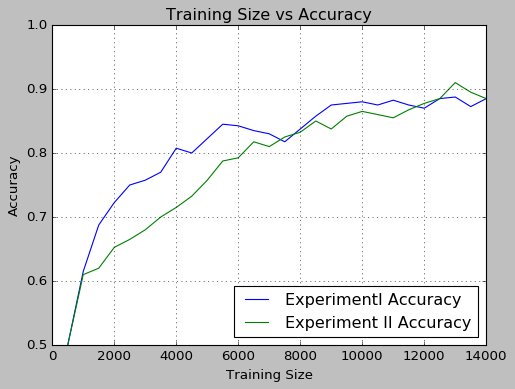

In [22]:
generate_size_graph(1, training_set_size, exp1_accuracy, exp2_accuracy, 500, 14000)

#### Experiment I vs Experiment II - 3500 images

In [16]:
training_set_size2 = [500, 1000, 1500, 2000, 2500, 3000, 3500]
exp2_accuracy2 = [0.53000000000000003, 0.66249999999999998, 0.67000000000000004, 0.68000000000000005, 0.66749999999999998, 0.6825, 0.69499999999999995]
exp1_accuracy2 = [0.56999999999999995, 0.69999999999999996, 0.6925, 0.67749999999999999, 0.65249999999999997, 0.68500000000000005, 0.72750000000000004]

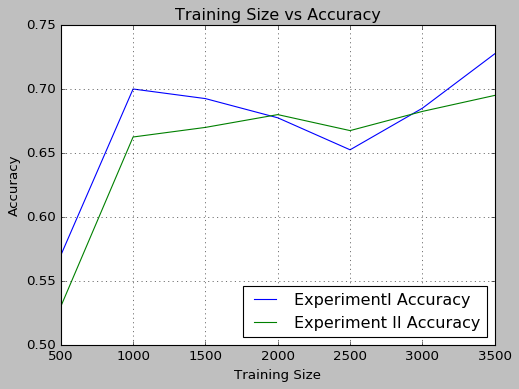

In [19]:
generate_size_graph(2, training_set_size2, exp1_accuracy2, exp2_accuracy2, 500, 3500)

#### Experiment I vs Experiment II - 800 images with 100-blocks each

In [14]:
training_set_size3 = [100, 200, 300, 400, 500, 600, 700, 800]
exp1_accuracy3 = [0.5, 0.5, 0.51249999999999996, 0.62250000000000005, 0.64500000000000002, 0.64500000000000002, 0.65000000000000002, 0.65749999999999997]
exp2_accuracy3 = [0.505, 0.5, 0.5, 0.52749999999999997, 0.61750000000000005, 0.57499999999999996, 0.59999999999999998, 0.60999999999999999]

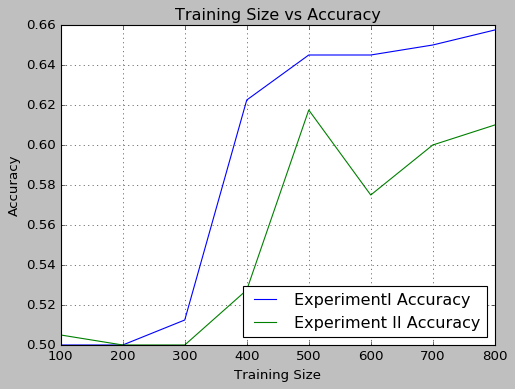

In [18]:
generate_size_graph(3, training_set_size3, exp1_accuracy3, exp2_accuracy3, 100, 800)